In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.misc
import os
%matplotlib inline


import cv2

In [2]:
import pdb
from time import sleep

import tensorflow.python.platform
from tensorflow.python.platform import gfile

from PIL import Image
import re

In [3]:
env = gym.make('MsPacman-v0')

[2017-05-09 11:55:06,061] Making new env: MsPacman-v0


In [26]:
def find_movers(s, s1, force_square=True):
    movers = []
    frame_diff = s1 - s
    fd_grey = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(fd_grey,1,255,cv2.THRESH_BINARY)[1]
    thresh_dilated = cv2.dilate(thresh,None,iterations=1)
    (cnts, _) = cv2.findContours(thresh_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    for i, c in enumerate(cnts):
        if cv2.contourArea(c) > 41:
            (x, y, w, h) = cv2.boundingRect(c)
            if force_square:
                if w < h:
                    deltaW = h - w
                    w = h
                    x = x - int(deltaW/2)
                elif h < w:
                    deltaH = w - h
                    h = w
                    y = y - int(deltaH/2)
            if (x >= 0) and (y >= 0):
                point0 = Point(x,y)
                point1 = Point(x+w, y+h)
                movers.append((point0, point1))
    return movers, thresh_dilated

def movers_mask(s, s1, shape):
    movers = find_movers(s, s1)
    mask = np.zeros(shape)
    for m in movers:
        mask[m[0]:m[1], m[2]:m[3]] = 1
    return mask

In [5]:
def init_pacman(env):
    env.reset()
    # nothing happens in first 100 steps of ms pacman
    for i in range(100):
        s,r,d,info = env.step(env.action_space.sample()) # take a random action
    return s,info


def dump_mover_images(num_steps, env, img_dir, debug=False):
    
    run_identifier = str(random.randint(0,1e6))
    
    s, info = init_pacman(env)
    
    for i in range(num_steps):
        
        if info['ale.lives'] == 0:
            s, info = init_pacman(env)
    
        s1,r,d,info = env.step(env.action_space.sample())
        
        s = s[:160,:]
        s1 = s1[:160,:]
        
        movers, thresh_dilated = find_movers(s, s1, force_square=True)
        
        for m in movers:
            m_image = Image.fromarray(s[m[0]:m[1], m[2]:m[3]])
            m_image.save(img_dir + run_identifier + 'img' + str(i) + '.jpg')
            
            if debug:
                # figures for debugging
                fig = plt.figure(figsize=(10,10))
                fig.add_subplot(121)
                plt.axis('off')
                plt.imshow(s[m[0]:m[1], m[2]:m[3]])
                ax = fig.add_subplot(122)
                plt.axis('off')
                plt.imshow(thresh_dilated)
                ax.add_patch(patches.Rectangle((m[2]-1,m[0]-1),m[3]-m[2],m[1]-m[0],color='g',fill=False))

                plt.show()
                pdb.set_trace()
        s = s1

In [166]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __repr__(self):
        return str((self.x, self.y))
    
    def sq_dist(self, p):
        return (self.x-p.x)**2 + (self.y-p.y)**2

class Mover():
    def __init__(self, mover_id, game_id, img_dir):
        self.trajectory = []
        self.id = mover_id
        self.img_dir = img_dir + 'mover' + str(self.id) + '/'
        os.mkdir(self.img_dir)
        self.features = None
        
    def add_observation(self, location, img):
        self.trajectory.append(location)
        img_for_save = Image.fromarray(img)
        img_for_save.save(self.img_dir + str(random.randint(0,1e6)) + '.jpg')

class MoverTracker():
    def __init__(self, game_id, img_dir, hyperparams):
        self.game_id = game_id
        self.n_movers = 0
        self.movers = []
        self.action_hist = []
        self.reward_hist = []
        self.img_dir = img_dir + str(game_id) + '/'
        os.mkdir(self.img_dir)
        self.hyperparams = hyperparams
        
    def process_frame_pair(self, frame_pair):
        self.action_hist.append(frame_pair.a)
        self.reward_hist.append(frame_pair.r)
        
        boxes = find_movers(frame_pair.s0, frame_pair.s1, \
                            force_square=self.hyperparams['force_square'])[0]
        if self.n_movers == 0:
            for i, box in enumerate(boxes):
                m = Mover(mover_id=i, game_id=self.game_id, img_dir=self.img_dir)
                img = frame_pair.s0[box[0].y:box[1].y, box[0].x:box[1].x]
                center = Point((box[0].x + box[1].x)/2, (box[0].y + box[1].y)/2)
                
                m.add_observation(center, img)
                self.movers.append(m)
                self.n_movers += 1
        else:
            cur_positions = [m.trajectory[-1] for m in self.movers]
            internal_dists = self.get_internal_dists(cur_positions)
            for i, box in enumerate(boxes):
                img = frame_pair.s0[box[0].y:box[1].y, box[0].x:box[1].x]
                center = Point((box[0].x + box[1].x)/2, (box[0].y + box[1].y)/2)
                
                box_id = self.identify_mover(center, cur_positions, internal_dists)
                if box_id >= self.n_movers:
                    # new mover
                    m = Mover(mover_id=box_id, game_id=self.game_id, img_dir=self.img_dir)
                    m.add_observation(center, img)
                    self.movers.append(m)
                    self.n_movers += 1
                else:
                    self.movers[box_id].add_observation(center, img)

                
    def identify_mover(self, center, cur_positions, internal_dists):
        dists = [center.sq_dist(p) for p in cur_positions]
        ind_min = np.argmin(dists)
        if dists[ind_min] > np.percentile(internal_dists,0.33):
            # above test is crude, refine later
            # new mover
            return self.n_movers
        else:
            return ind_min
        
    def get_internal_dists(self, cur_positions):
        internal_dists = []
        for i, p1 in enumerate(cur_positions):
            for j, p2 in enumerate(cur_positions[:i]):
                internal_dists.append(p1.sq_dist(p2))
        return internal_dists
    
class FramePair():
    def __init__(self, s0, s1, a, r):
        self.s0 = s0
        self.s1 = s1
        self.a = a
        self.r = r

In [167]:
def play(num_steps, env, img_dir, debug=False, hyperparams={'force_square':True}):
    
    game_id = str(random.randint(0,1e6))
    
    mover_tracker = MoverTracker(game_id, img_dir, hyperparams)
    
    s0, info = init_pacman(env)
    
    for i in range(num_steps):
        
        if info['ale.lives'] == 0:
            s0, info = init_pacman(env)
    
        a = env.action_space.sample()
        s1,r,d,info = env.step(a)
        
        s0 = s0[:160,:]
        s1 = s1[:160,:]

        frame_pair = FramePair(s0, s1, a, r)
        
        mover_tracker.process_frame_pair(frame_pair)
        
        s0 = s1
    
    return mover_tracker

In [168]:
num_steps = 20
img_dir = 'img/'
mt = play(num_steps, env, img_dir)
print mt.game_id

981749


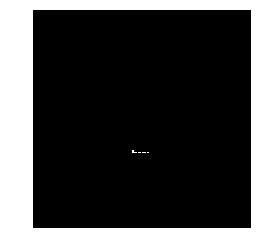

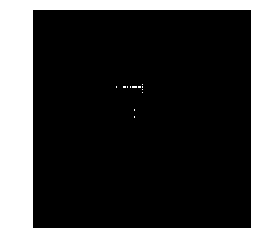

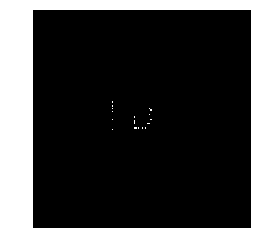

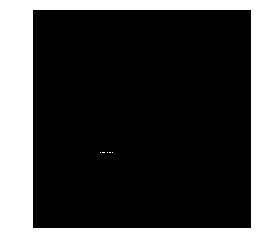

In [169]:
for m in mt.movers:
    plt.figure()
    plt.axis('off')
    darkFrame = np.zeros((160,160,3))

    for p in m.trajectory:
        darkFrame[int(p.y), int(p.x), :] = 1

    plt.imshow(darkFrame)

In [65]:
num_steps = 200
img_dir = 'img/'

dump_mover_images(num_steps, env, img_dir)

IndexError: tuple index out of range

In [ ]:
a = np.random.randint(0,9)

s,r,d,info = env.step(a)

a = np.random.randint(0,9)

s1,r,d,info = env.step(a)

a = np.random.randint(0,9)

s2,r,d,info = env.step(a)

plt.imshow(s1[:160,:])

frame_diff = s1[:160,:]-s[:160,:]
frame_diff_2 = s2[:160,:]-s1[:160,:]

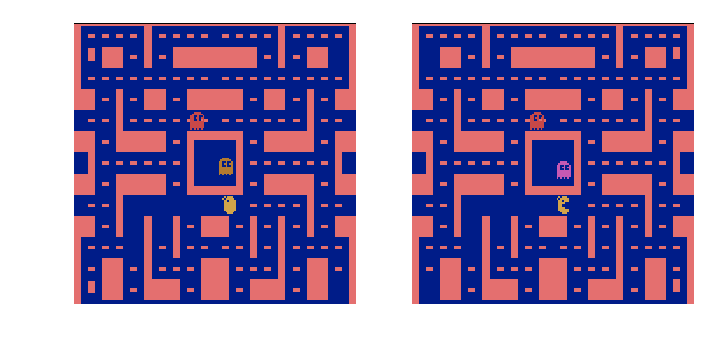

2
107.0


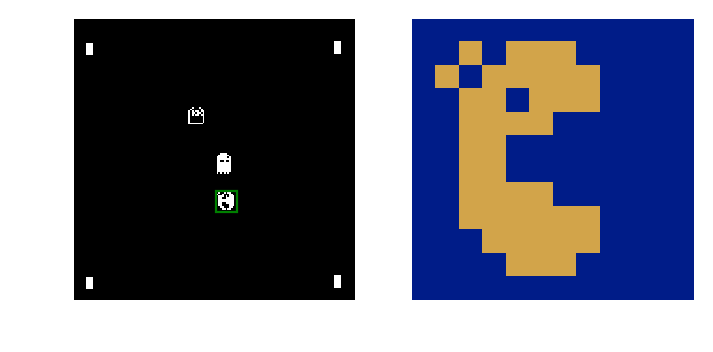

3
112.5


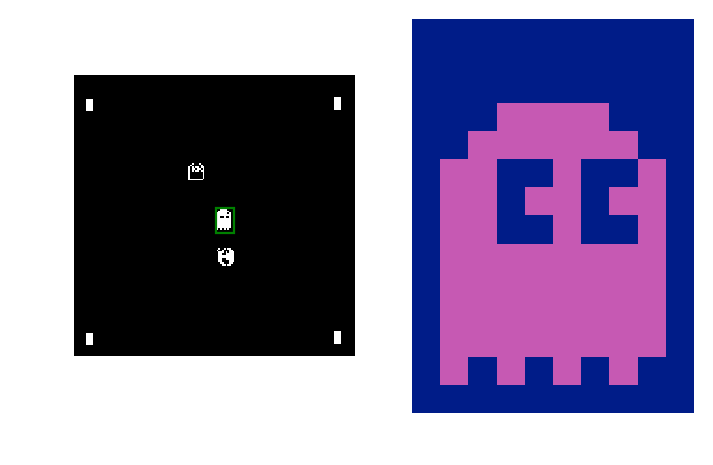

KeyboardInterrupt: 

In [35]:


test=cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(test,1,255,cv2.THRESH_BINARY)[1]
thresh_dilated = cv2.dilate(thresh,None,iterations=1)
(cnts, _) = cv2.findContours(thresh_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
thresh = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

fig = plt.figure(figsize=(5,5),dpi=160)
fig.add_subplot(121)
plt.axis('off')
plt.imshow(s1[:160,:])
fig.add_subplot(122)
plt.imshow(s[:160,:])
plt.axis('off')
plt.show()

objects = []
movers = find_movers(s, s1)

for i, c in enumerate(cnts):
    if cv2.contourArea(c) > 41:
        (x, y, w, h) = cv2.boundingRect(c)
        fig = plt.figure(figsize=(5,5),dpi=160)
        ax = fig.add_subplot(121)
        plt.axis('off')
        #plt.imshow(thresh[y:y+h,x:x+w])
        plt.imshow(thresh)
        print i
        print cv2.contourArea(c)
        plt.axis([1, 160, 160, 1])
        ax.add_patch(patches.Rectangle((x,y),w,h,color='g',fill=False))
        ax = fig.add_subplot(122)
        plt.axis('off')
        plt.imshow(s[y:y+h,x:x+w])
        objects.append(s[y:y+h,x:x+w])
        plt.show()

In [ ]:
plt.imshow(s[y:y+h,x:x+w])
plt.axis('off')

In [141]:
sess = tf.Session()

net = DynNetwork()

sess.run(tf.variables_initializer(tf.global_variables()))

In [ ]:
class DynNetwork():
    def __init__(self):
        #self.scalarInputFrame0 =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        #self.imageInFrame0 = tf.reshape(self.scalarInputFrame0,shape=[-1,84,84,3])

        #self.scalarInputFrame1 =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        #self.imageInFrame1 = tf.reshape(self.scalarInputFrame1,shape=[-1,84,84,3])
        
        self.imageInFrame0 = tf.placeholder(shape=[1,160,160,3],dtype=tf.float32,name='imageInFrame0')
        self.imageInFrame1 = tf.placeholder(shape=[1,160,160,3],dtype=tf.float32,name='imageInFrame1')

        #self.action = tf.placeholder(shape=[1],dtype=tf.int32)
        
        with tf.variable_scope('conv1') as scope:
            kernel = tf.Variable(tf.truncated_normal([4, 4, 3, 16], dtype=tf.float32,\
                                               stddev=1e-1))
            biases = tf.Variable(tf.constant(0.0, shape=[16], dtype=tf.float32),
                           trainable=True)

            conv_F0 = tf.nn.conv2d(self.imageInFrame0, kernel, [1, 2, 2, 1], padding='SAME')
            conv_F1 = tf.nn.conv2d(self.imageInFrame1, kernel, [1, 2, 2, 1], padding='SAME')

            bias_F0 = tf.nn.bias_add(conv_F0, biases)
            bias_F1 = tf.nn.bias_add(conv_F1, biases)

            self.conv1_F0 = tf.nn.relu(bias_F0,name=scope.name)
            self.conv1_F1 = tf.nn.relu(bias_F1,name=scope.name)

        with tf.variable_scope('conv2') as scope:
            kernel = tf.Variable(tf.truncated_normal([4, 4, 16, 8], dtype=tf.float32,\
                                               stddev=1e-1))
            biases = tf.Variable(tf.constant(0.0, shape=[8], dtype=tf.float32),
                           trainable=True)

            conv_F0 = tf.nn.conv2d(self.conv1_F0, kernel, [1, 2, 2, 1], padding='SAME')
            conv_F1 = tf.nn.conv2d(self.conv1_F1, kernel, [1, 2, 2, 1], padding='SAME')

            bias_F0 = tf.nn.bias_add(conv_F0, biases)
            bias_F1 = tf.nn.bias_add(conv_F1, biases)

            self.conv2_F0 = tf.nn.relu(bias_F0,name=scope.name)
            self.conv2_F1 = tf.nn.relu(bias_F1,name=scope.name)
        '''
        with tf.variable_scope('conv3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 8], dtype=tf.float32,\
                                               stddev=1e-1))
            biases = tf.Variable(tf.constant(0.0, shape=[8], dtype=tf.float32),
                           trainable=True)

            conv_F0 = tf.nn.conv2d(self.conv2_F0, kernel, [1, 1, 1, 1], padding='SAME')
            conv_F1 = tf.nn.conv2d(self.conv2_F1, kernel, [1, 1, 1, 1], padding='SAME')

            bias_F0 = tf.nn.bias_add(conv_F0, biases)
            bias_F1 = tf.nn.bias_add(conv_F1, biases)

            self.conv3_F0 = tf.nn.relu(bias_F0,name=scope.name)
            self.conv3_F1 = tf.nn.relu(bias_F1,name=scope.name)
        
        '''
        with tf.variable_scope('conv_diff') as scope:
            nonzero_weightsF0 = tf.Variable(tf.truncated_normal([2, 2, 8], dtype=tf.float32,\
                                                                    stddev=1e-1), name='nonzero_weightsF0')
            nonzero_weightsF1 = tf.Variable(tf.truncated_normal([2, 2, 8], dtype=tf.float32,\
                                                                    stddev=1e-1), name='nonzero_weightsF1')
            weightsF0 = tf.matrix_set_diag(tf.zeros([2,2,8,8]),nonzero_weightsF0)
            weightsF1 = tf.matrix_set_diag(tf.zeros([2,2,8,8]),nonzero_weightsF1)
            kernel = tf.concat([weightsF0,weightsF1],2)
            
            biases = tf.Variable(tf.constant(0.0, shape=[8], dtype=tf.float32),
                           trainable=True)
            conv2_both = tf.concat([self.conv2_F0, self.conv2_F1],3)
            
            conv = tf.nn.conv2d(conv2_both, kernel, [1, 2, 2, 1], padding='SAME')
            
            bias = tf.nn.bias_add(conv, biases)
            self.conv_diff = tf.nn.relu(bias, name=scope.name)
        
        #self.cdf = slim.flatten(self.conv_diff)
        #self.fc = slim.fully_connected(self.cdf, 3)
        #self.logits = tf.concat([self.fc, [[1]]],1)
        
        self.movers_mask = tf.placeholder(shape=[1,160,160,1],dtype=tf.float32)
        #self.frame_diff_scalar = tf.reshape(self.frame_diff,[1,21168])
        
        nonzero_weightsOut = tf.Variable(tf.truncated_normal([8,8,8,1], dtype=tf.float32,\
                                                                stddev=1e-1), name='nonzero_weightsOut')

        biases = tf.Variable(tf.constant(0.0, shape=[1,160,160,1], dtype=tf.float32),
                           trainable=True)
        
        weightsProd = tf.tensordot(self.conv_diff, nonzero_weightsOut, [[3],[0]])

        
        channels = tf.unstack(weightsProd,axis=5)
        screen_channels = []
        for ch in channels:
            full_cols=[tf.reshape(t,[160,8]) for t in tf.unstack(ch,axis=1)]
            screen_channels.append(tf.concat(full_cols,1))
        weightsProd_screen = tf.stack(screen_channels,axis=2)
        
        bias = tf.add(weightsProd_screen, biases)
            
        self.out = tf.nn.relu(bias, name=scope.name)

        #self.loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.action, logits=self.logits))
        
        self.loss = tf.reduce_sum(tf.square(self.movers_mask - self.out))
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.update_model = self.trainer.minimize(self.loss)
        

In [ ]:
num_steps = 50000

env.reset()

# nothing happens in first 100 steps of ms pacman
for i in range(100):
    s,r,d,info = env.step(env.action_space.sample()) # take a random action

losses = []

for i in range(num_steps):
    
    if info['ale.lives'] == 0:
        s = env.reset()
        for i in range(100):
            s,r,d,info = env.step(env.action_space.sample()) # take a random action

    a = np.random.randint(0,9)
    s1,r,d,info = env.step(a)

    s = s[:160,:]
    s1 = s1[:160,:]
    
    mask = np.expand_dims(movers_mask(s, s1, s.shape[:2]),2)
    [dummy, loss] = sess.run([net.update_model, net.loss], \
                             feed_dict={net.imageInFrame0:[s],\
                                        net.imageInFrame1:[s1],\
                                        net.movers_mask: [mask]})
    losses.append(loss)

    if i % 500 == 0:
        print i
        print losses[i]
        
        out = sess.run(tf.reshape(net.out,[160,160,1]), \
                             feed_dict={net.imageInFrame0:[s],\
                                        net.imageInFrame1:[s1],\
                                        net.movers_mask: [mask]})
        out_im = np.reshape(out,s.shape[:2])
        mask_im = np.reshape(mask,s.shape[:2])
        plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.axis('off')
        plt.imshow(out_im,cmap='gray')
        plt.subplot(122)
        plt.axis('off')
        plt.imshow(mask_im,cmap='gray')
        
        plt.show()
        pdb.set_trace()
        
    s = s1
    

In [ ]:
sess.close()

In [ ]:
plt.plot(losses[100:],'o')

In [6]:
def play_centers(env, num_steps, debug=False):
    s, info = init_pacman(env)

    centers = []
    
    for step in range(num_steps):
        
        if info['ale.lives'] == 0:
            s, info = init_pacman(env)
    
        s1,r,d,info = env.step(env.action_space.sample())
        
        s = s[:160,:]
        s1 = s1[:160,:]
        
        movers, thresh_dilated = find_movers(s, s1, force_square=False)
        
        if debug:
            fig = plt.figure(figsize=(10,10))
            fig.add_subplot(121)
            plt.imshow(s)
            fig.add_subplot(122)
            plt.imshow(s,alpha=0.5)
            plt.imshow(s1,alpha=0.5)

        curCenters = []
        
        for i, m in enumerate(movers):
            if debug:
                fig = plt.figure(figsize=(10,10))
                fig.add_subplot(121)
                plt.axis('off')
                plt.imshow(s[m[0]:m[1], m[2]:m[3]])
                ax = fig.add_subplot(122)
                plt.axis('off')
                plt.imshow(thresh_dilated)
                ax.add_patch(patches.Rectangle((m[2]-1,m[0]-1),m[3]-m[2],m[1]-m[0],color='g',fill=False))
                print 'Mover ' + str(i) + '\n' + 'Center: ' + str( (centerX, centerY) )
                plt.show()
            
            centerX = m[2] + (m[3]-m[2])/2; centerY = m[0] + (m[1]-m[0])/2
            curCenters.append((centerX,centerY))


        if debug:
            fig = plt.figure(figsize=(10,10))
            fig.add_subplot(121)
            plt.axis('off')
            darkFrame = np.zeros((160,160,3))
            frame_colors = {0: [1,0,0], 1:[0,1,0]}
            for frame_num, frame in enumerate(centers[-2:]):
                for center in frame:
                    darkFrame[int(center[1]),int(center[0]),:] = frame_colors[frame_num]
            plt.imshow(darkFrame)

            plt.show()
            pdb.set_trace()
        
        
        centers.append(curCenters)
        s = s1
    return centers